# Chunking: the key to scaling with Dask and Xarray

This notebook contains the code related to my [blog post]() about the importance of chunking in Xarray and Dask. Read that for more information.

### The vanilla unstacked dataset.

In [31]:
import xarray as xr
import dask.array as da
import numpy as np
from blockwise_stack import blockwise_stack


one_to_six = np.array([[1, 2, 3], [4, 5, 6]])


ds = xr.Dataset(
    {
        "data": (
            ["y", "x", "band"],
            da.random.random((4, 6, 3), chunks=(2, 2, -1)),
        )
    },
    coords={
        "chunk_idx": (
            ("y", "x"),
            np.repeat(np.repeat(one_to_six, 2, axis=0), 2, axis=1),
        )
    },
)
ds.data

<xarray.DataArray 'data' (y: 4, x: 6, band: 3)>
dask.array<random_sample, shape=(4, 6, 3), dtype=float64, chunksize=(2, 2, 3), chunktype=numpy.ndarray>
Coordinates:
    chunk_idx  (y, x) int64 1 1 2 2 3 3 1 1 2 2 3 3 4 4 5 5 6 6 4 4 5 5 6 6
Dimensions without coordinates: y, x, band

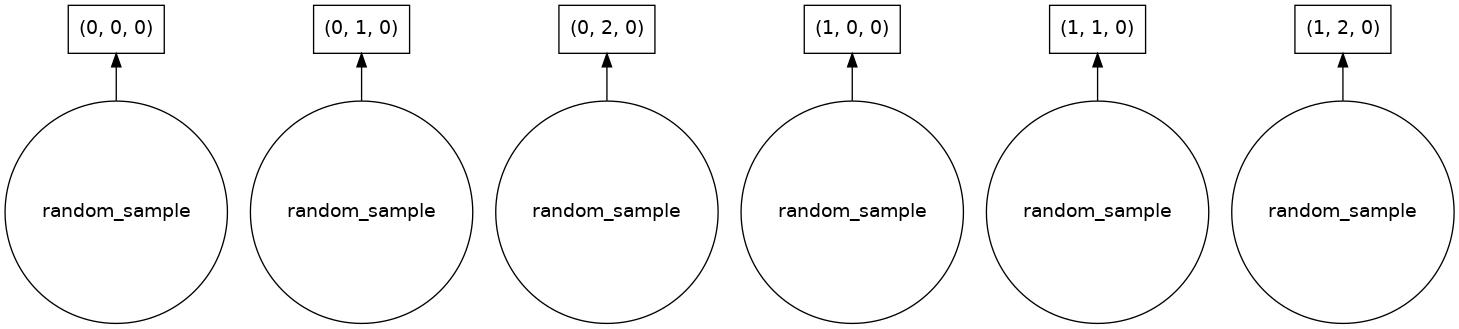

In [32]:
ds.data.data.visualize("vanilla.png")

In [33]:
ds.chunk_idx

<xarray.DataArray 'chunk_idx' (y: 4, x: 6)>
array([[1, 1, 2, 2, 3, 3],
       [1, 1, 2, 2, 3, 3],
       [4, 4, 5, 5, 6, 6],
       [4, 4, 5, 5, 6, 6]])
Coordinates:
    chunk_idx  (y, x) int64 1 1 2 2 3 3 1 1 2 2 3 3 4 4 5 5 6 6 4 4 5 5 6 6
Dimensions without coordinates: y, x

In [34]:
ds.data.chunks

((2, 2), (2, 2, 2), (3,))

In [35]:
ds.data.compute()

<xarray.DataArray 'data' (y: 4, x: 6, band: 3)>
array([[[0.13139708, 0.19549958, 0.66861426],
        [0.94335004, 0.28676908, 0.93161289],
        [0.04099033, 0.0836226 , 0.5460762 ],
        [0.24185003, 0.32280634, 0.7680797 ],
        [0.68783277, 0.5290929 , 0.91846739],
        [0.94354277, 0.46614519, 0.76891096]],

       [[0.30066817, 0.16093608, 0.90023949],
        [0.02335407, 0.30185911, 0.29812857],
        [0.04895533, 0.00391955, 0.9646891 ],
        [0.46754203, 0.7254627 , 0.94027682],
        [0.19849697, 0.69532653, 0.76382107],
        [0.72206202, 0.60349591, 0.50277971]],

       [[0.58719441, 0.49343886, 0.15138643],
        [0.25816612, 0.13146473, 0.61667023],
        [0.17156331, 0.29370808, 0.94315776],
        [0.85263735, 0.28657576, 0.87703606],
        [0.55595397, 0.45120449, 0.75633014],
        [0.33015102, 0.14205271, 0.75757339]],

       [[0.90688208, 0.65059615, 0.97585856],
        [0.99297633, 0.5510722 , 0.63908776],
        [0.13901328, 0.48361927, 0.87666734],
        [0.29749553, 0.58191102, 0.54651696],
        [0.76802647, 0.78926123, 0.94551743],
        [0.85309397, 0.75001232, 0.08170788]]])
Coordinates:
    chunk_idx  (y, x) int64 1 1 2 2 3 3 1 1 2 2 3 3 4 4 5 5 6 6 4 4 5 5 6 6
Dimensions without coordinates: y, x, band

### Xarray's version of the stacked dataset.

Note how every output chunk is dependent on **three** input chunks.

In [36]:
stacked = ds.stack(pixel=("y", "x"))
stacked.data

<xarray.DataArray 'data' (band: 3, pixel: 24)>
dask.array<reshape, shape=(3, 24), dtype=float64, chunksize=(3, 6), chunktype=numpy.ndarray>
Coordinates:
    chunk_idx  (pixel) int64 1 1 2 2 3 3 1 1 2 2 3 3 4 4 5 5 6 6 4 4 5 5 6 6
  * pixel      (pixel) MultiIndex
  - y          (pixel) int64 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3
  - x          (pixel) int64 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5
Dimensions without coordinates: band

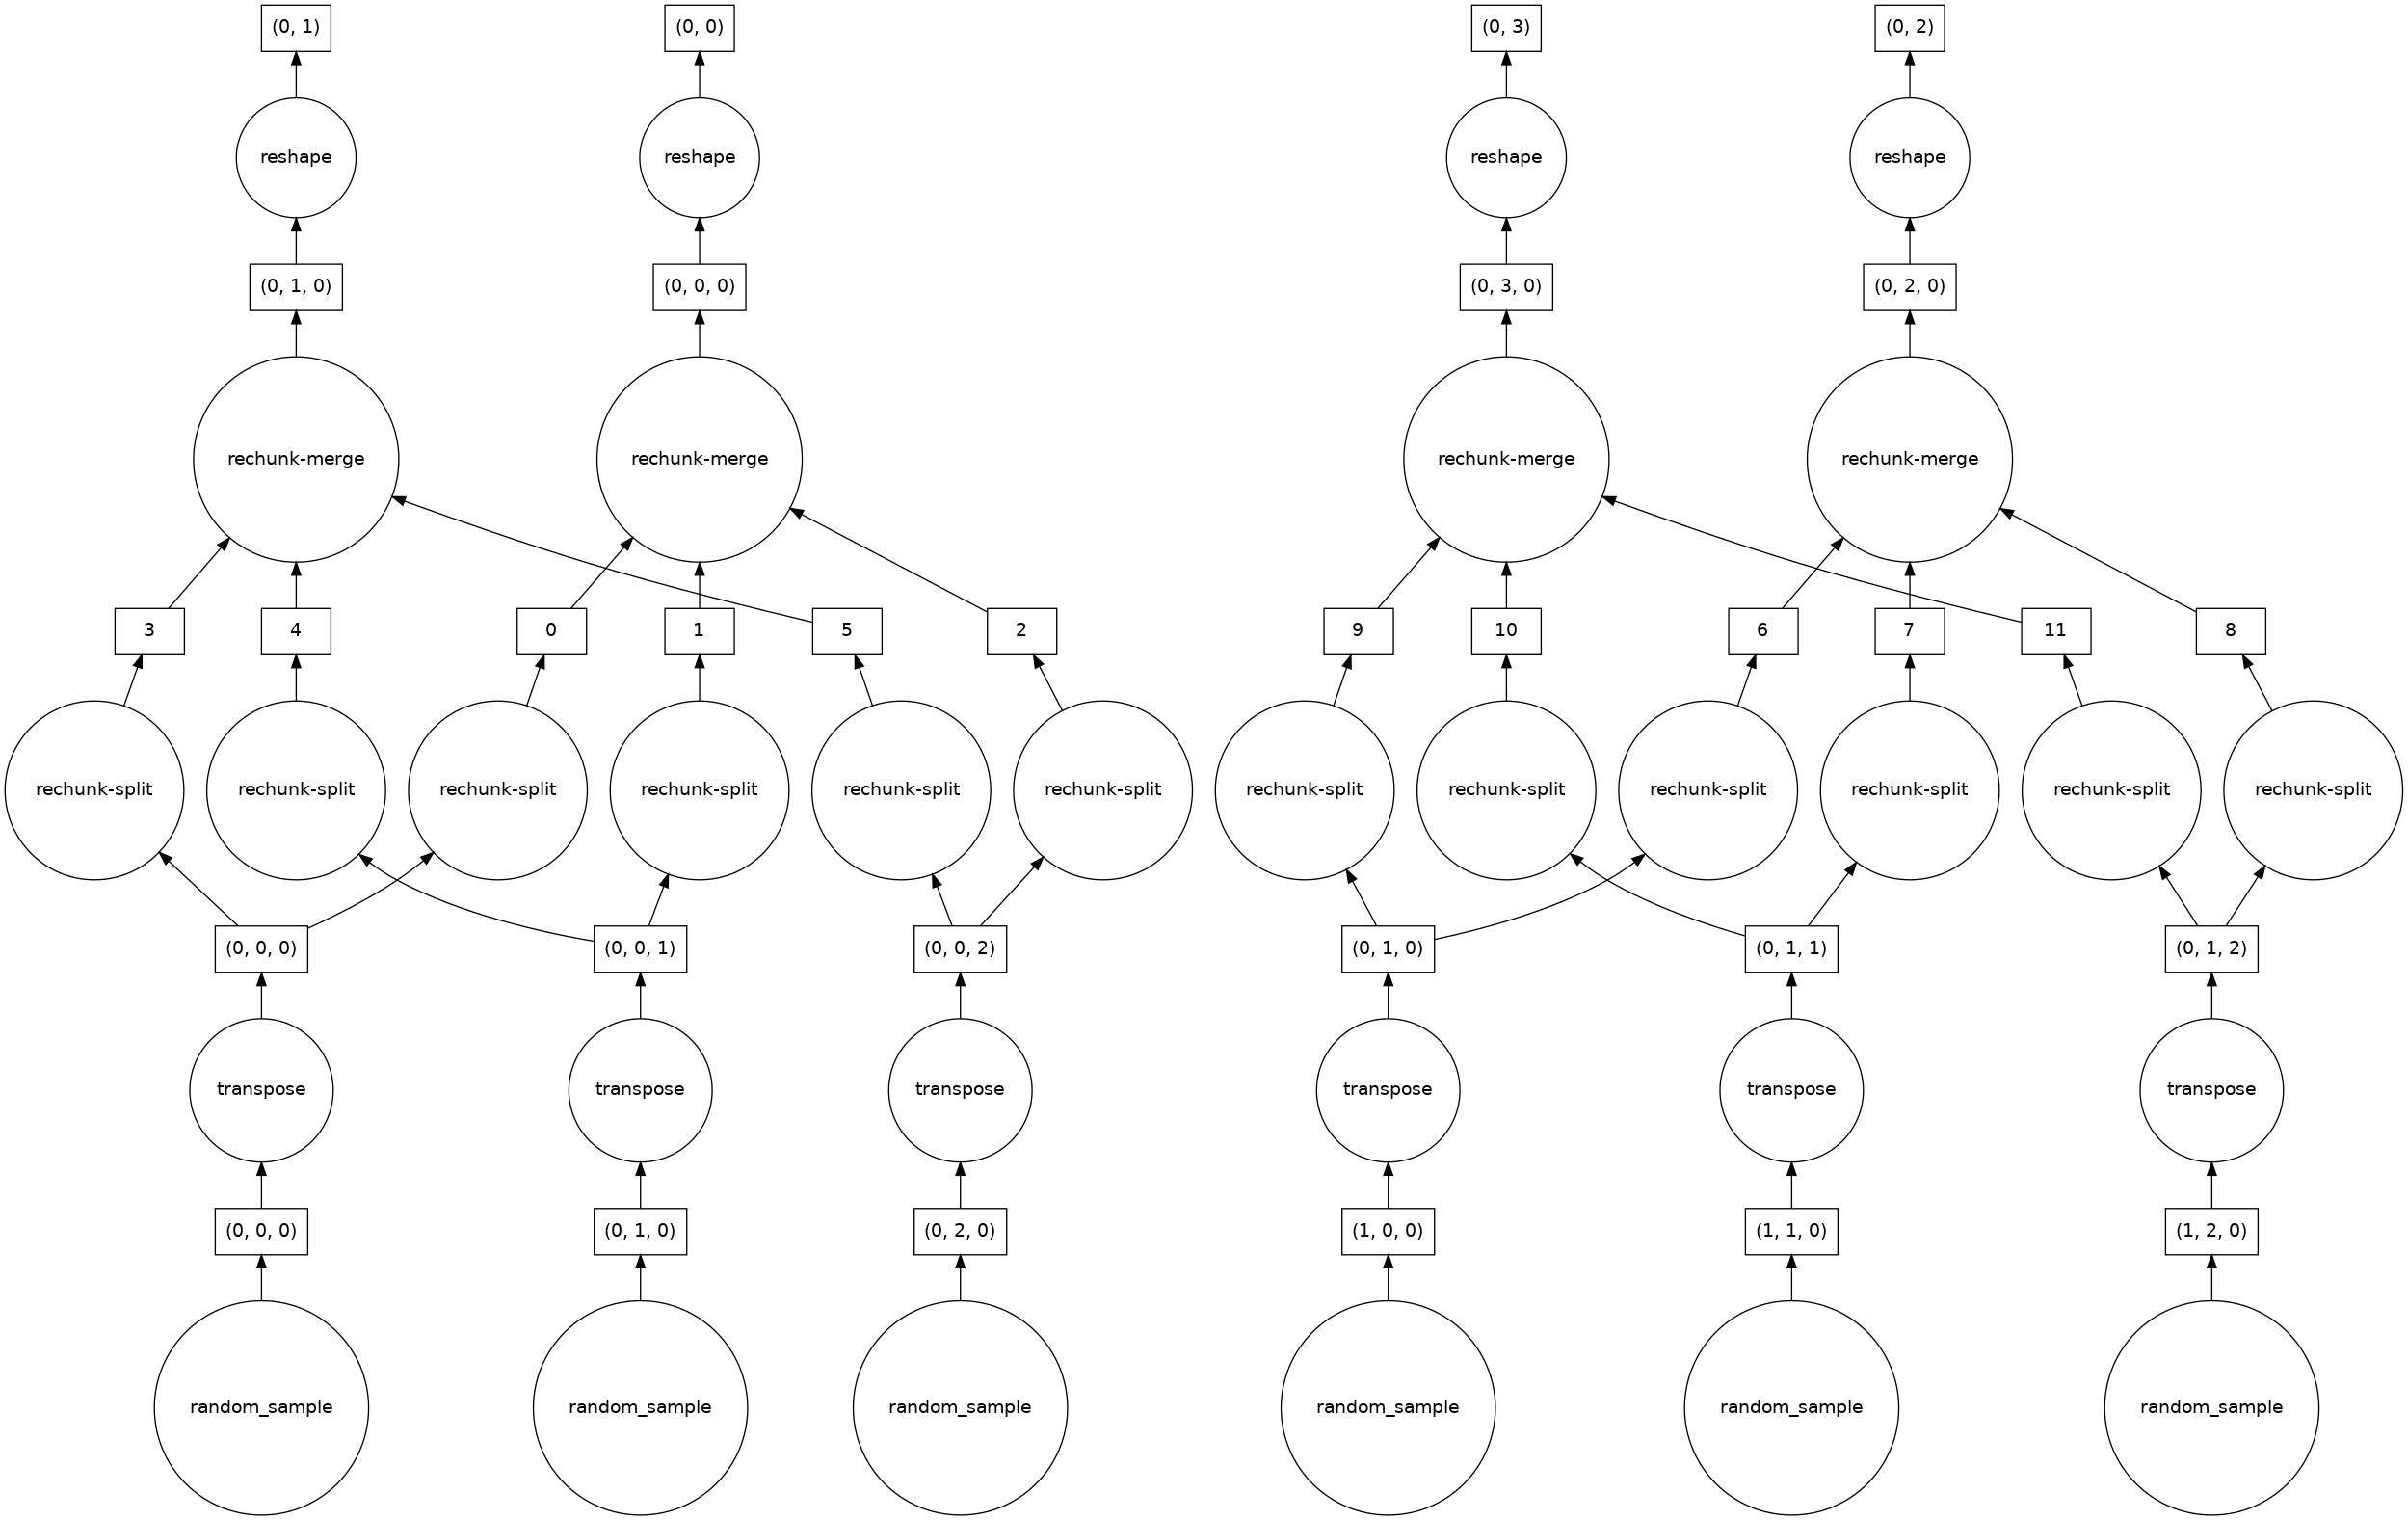

In [37]:
stacked.data.data.visualize(filename="./stacked.png")

In [38]:
stacked.chunk_idx

<xarray.DataArray 'chunk_idx' (pixel: 24)>
array([1, 1, 2, 2, 3, 3, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 4, 4, 5, 5,
       6, 6])
Coordinates:
    chunk_idx  (pixel) int64 1 1 2 2 3 3 1 1 2 2 3 3 4 4 5 5 6 6 4 4 5 5 6 6
  * pixel      (pixel) MultiIndex
  - y          (pixel) int64 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3
  - x          (pixel) int64 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5

In [39]:
stacked.data.chunks

((3,), (6, 6, 6, 6))

In [40]:
stacked.data.compute()

<xarray.DataArray 'data' (band: 3, pixel: 24)>
array([[0.13139708, 0.94335004, 0.04099033, 0.24185003, 0.68783277,
        0.94354277, 0.30066817, 0.02335407, 0.04895533, 0.46754203,
        0.19849697, 0.72206202, 0.58719441, 0.25816612, 0.17156331,
        0.85263735, 0.55595397, 0.33015102, 0.90688208, 0.99297633,
        0.13901328, 0.29749553, 0.76802647, 0.85309397],
       [0.19549958, 0.28676908, 0.0836226 , 0.32280634, 0.5290929 ,
        0.46614519, 0.16093608, 0.30185911, 0.00391955, 0.7254627 ,
        0.69532653, 0.60349591, 0.49343886, 0.13146473, 0.29370808,
        0.28657576, 0.45120449, 0.14205271, 0.65059615, 0.5510722 ,
        0.48361927, 0.58191102, 0.78926123, 0.75001232],
       [0.66861426, 0.93161289, 0.5460762 , 0.7680797 , 0.91846739,
        0.76891096, 0.90023949, 0.29812857, 0.9646891 , 0.94027682,
        0.76382107, 0.50277971, 0.15138643, 0.61667023, 0.94315776,
        0.87703606, 0.75633014, 0.75757339, 0.97585856, 0.63908776,
        0.87666734, 0.54651696, 0.94551743, 0.08170788]])
Coordinates:
    chunk_idx  (pixel) int64 1 1 2 2 3 3 1 1 2 2 3 3 4 4 5 5 6 6 4 4 5 5 6 6
  * pixel      (pixel) MultiIndex
  - y          (pixel) int64 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3
  - x          (pixel) int64 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5 0 1 2 3 4 5
Dimensions without coordinates: band

### A dataset that's stacked "blockwise".

Note how every output chunk is dependent on **one** input chunk.

In [41]:
# blockwise_stack only works if all data variables and coordinates are Dask arrays.
# (They also have to be chunked with an identical schema, but there's not check for that.)
fully_chunked_ds = ds.copy()
fully_chunked_ds.coords["chunk_idx"] = (
    ("y", "x"),
    da.from_array(fully_chunked_ds.chunk_idx.values, chunks=(2, 2)),
)

stacked_blockwise = blockwise_stack(
    fully_chunked_ds,
    input_dims=("y", "x"),
    output_dim="pixel",
    ds_chunks={"y": 2, "x": 2, "band": -1},
)
stacked_blockwise.data

<xarray.DataArray 'data' (band: 3, pixel: 24)>
dask.array<blockwise-stack, shape=(3, 24), dtype=float64, chunksize=(3, 4), chunktype=numpy.ndarray>
Coordinates:
    chunk_idx  (pixel) int64 dask.array<chunksize=(4,), meta=np.ndarray>
Dimensions without coordinates: band, pixel

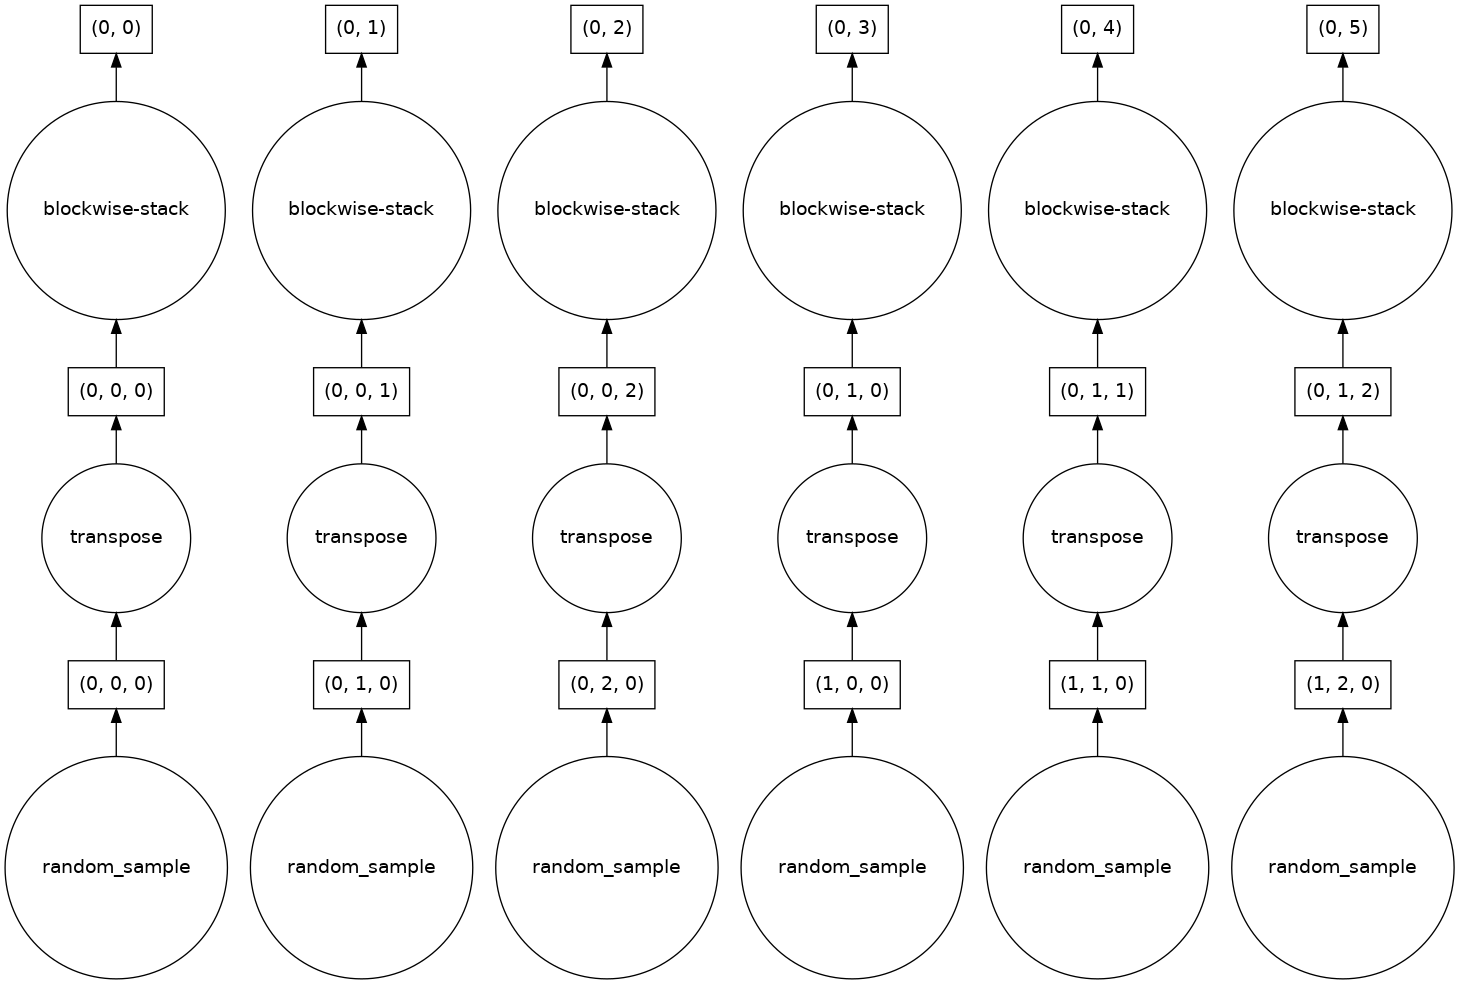

In [42]:
stacked_blockwise.data.data.visualize(filename="blockwise_stacked.png")

In [43]:
stacked_blockwise.chunk_idx.compute()

<xarray.DataArray 'chunk_idx' (pixel: 24)>
array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6,
       6, 6])
Coordinates:
    chunk_idx  (pixel) int64 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6
Dimensions without coordinates: pixel

In [44]:
stacked_blockwise.data.chunks

((3,), (4, 4, 4, 4, 4, 4))

In [45]:
stacked_blockwise.data.compute()

<xarray.DataArray 'data' (band: 3, pixel: 24)>
array([[0.13139708, 0.94335004, 0.30066817, 0.02335407, 0.04099033,
        0.24185003, 0.04895533, 0.46754203, 0.68783277, 0.94354277,
        0.19849697, 0.72206202, 0.58719441, 0.25816612, 0.90688208,
        0.99297633, 0.17156331, 0.85263735, 0.13901328, 0.29749553,
        0.55595397, 0.33015102, 0.76802647, 0.85309397],
       [0.19549958, 0.28676908, 0.16093608, 0.30185911, 0.0836226 ,
        0.32280634, 0.00391955, 0.7254627 , 0.5290929 , 0.46614519,
        0.69532653, 0.60349591, 0.49343886, 0.13146473, 0.65059615,
        0.5510722 , 0.29370808, 0.28657576, 0.48361927, 0.58191102,
        0.45120449, 0.14205271, 0.78926123, 0.75001232],
       [0.66861426, 0.93161289, 0.90023949, 0.29812857, 0.5460762 ,
        0.7680797 , 0.9646891 , 0.94027682, 0.91846739, 0.76891096,
        0.76382107, 0.50277971, 0.15138643, 0.61667023, 0.97585856,
        0.63908776, 0.94315776, 0.87703606, 0.87666734, 0.54651696,
        0.75633014, 0.75757339, 0.94551743, 0.08170788]])
Coordinates:
    chunk_idx  (pixel) int64 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6
Dimensions without coordinates: band, pixel